# Predictive Luong Baseline

In [1]:
# Which GPU is being used?
! nvidia-smi

Tue Mar 16 14:57:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import re
import io
import unicodedata
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tensorflow.keras import layers as L
from sklearn.model_selection import train_test_split

# For reproducibility
tf.random.set_seed(666)
os.environ['PYTHONHASHSEED'] = str(666)
np.random.seed(666)

# Utilities And Downloads

We use `tf.keras.utils.get_file` to download the English to Spanish dataset hosted by Google. We define the file name where the script will save the dataset

In [3]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

print(f"[INFO] PATH TO ZIP: {path_to_zip}")

2646016/2638744 [==============================] - 0s 0us/step
[INFO] PATH TO ZIP: /root/.keras/datasets/spa-eng.zip


In [4]:
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

print(f"[INFO] PATH TO FILE: {path_to_file}")

[INFO] PATH TO FILE: /root/.keras/datasets/spa-eng/spa.txt


# Preprocessing functions
In the later snippets we use some functions that are used to pre-process the data.




In [5]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn')

In [6]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [7]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [8]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [9]:
en, sp = create_dataset(path_to_file, None)
print(en[100])
print(sp[100])

<start> go away ! <end>
<start> salga de aqui ! <end>


In [10]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post')

    return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_dataset(path , num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
num_examples = 70_000
(input_tensor,target_tensor,inp_lang,targ_lang) = load_dataset(path_to_file,num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [13]:
print(f'[INFO] Max length of target: {max_length_targ}')
print(f'[INFO] Max length of input: {max_length_inp}')

[INFO] Max length of target: 20
[INFO] Max length of input: 14


# Dataset
Here we use the `tf.data.Dataset` API for better dataset pipeline.

In [14]:
# Creating training and validation sets using an 80-20 split
(input_tensor_train,input_tensor_val,target_tensor_train,target_tensor_val) = train_test_split(input_tensor,target_tensor,test_size=0.3)
(input_tensor_val,input_tensor_test,target_tensor_val,target_tensor_test) = train_test_split(input_tensor_val,target_tensor_val,test_size=0.6)

# Show length
print(f'[INFO] Input_Train: {input_tensor_train.shape} Target_Train: {target_tensor_train.shape}')
print(f'[INFO] Input_Val: {input_tensor_val.shape} Target_Val: {target_tensor_val.shape}')
print(f'[INFO] Input_Test: {input_tensor_test.shape} Target_Test: {target_tensor_test.shape}')

[INFO] Input_Train: (49000, 14) Target_Train: (49000, 20)
[INFO] Input_Val: (8400, 14) Target_Val: (8400, 20)
[INFO] Input_Test: (12600, 14) Target_Test: (12600, 20)


In [15]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> i
29 ----> can
132 ----> still
266 ----> hear
32 ----> your
761 ----> voice
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
124 ----> todavia
46 ----> puedo
920 ----> oir
28 ----> tu
599 ----> voz
3 ----> .
2 ----> <end>


# NMT with Luong
In this section we discuss the implementation of attention with NMT as mentioned by [Luong et al](https://arxiv.org/abs/1508.04025).

In [17]:
# GLOBAL VARIABLES
BUFFER_SIZE_TRAIN = len(input_tensor_train)
BUFFER_SIZE_VAL = len(input_tensor_val)
BATCH_SIZE = 1000
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

train_ds = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE_TRAIN)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

val_ds = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE_VAL)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(BUFFER_SIZE_VAL)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

#Local Attention

$$ p_t = align(h_t,\overline{h_s})\exp(-\frac{(s-p_t)^2}{2\sigma^2}) $$

In [18]:
# Hyperparams for Luong
D = 4
sigma = D/2

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self,
               vocab_size,
               embedding_dim,
               enc_units,
               batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = L.Embedding(vocab_size, embedding_dim)
    self.gru = L.GRU(self.enc_units,
                     return_sequences=True,
                     return_state=True,
                     recurrent_initializer='glorot_uniform')

  def call(self,
           x,
           hidden_fd):
    x = self.embedding(x)
    output, fd_state = self.gru(x, initial_state = [hidden_fd])
    return output, fd_state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
initial_fwd = encoder.initialize_hidden_state()
for en, sp in train_ds.take(1):
    sample_output, sample_hidden_fwd = encoder(en, initial_fwd)
    print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
    print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden_fwd.shape))

Encoder output shape: (batch size, sequence length, units) (1000, 14, 1024)
Encoder Hidden state shape: (batch size, units) (1000, 1024)


# Global Attention
- We get the hidden state of the decoder $h_{t}$.
- We send the decoder hidden state to the attention layer.
- The attention layer produces alignment $a_{t}$ between the decoder $h_{t}$ and the encoder hidden states $\overline{h_{s}}$.
$$
a_{t}=\sigma({score(\overline{h_s},h_t)})\\
score(\overline{h_s},h_t)=v_{a}^{T}\tanh({W_{a}[h_t;\overline{h_s}]})
$$
- We then use the weighted average of the alignment matrix with the encoder hhidden states to get the context vector $c_{t}$
$$
c_{t}=\sum{a_{t}\times{\overline{h_s}}}
$$
- Now the context vector $c_{t}$ is fed into a dense layer so that we obtain the mutated decoder hidden state $\overline{h_t}$
$$
\overline{h_t}=\tanh{(W_c[c_t;h_t])}\\
p(y_t|y_{<t},x)=\sigma(W_s\overline{h_t})
$$

In case of Loccal attention, we are using a factor $ p_t $ to define the center index of our attention window (span) to avoid unneccessary computations 
$$ p_t = align(h_t,\overline{h_s})\exp(-\frac{(s-p_t)^2}{2\sigma^2}) $$

In [27]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W1 = L.Dense(units)
    self.W2 = L.Dense(units)
    self.W3 = L.Dense(units)
    self.W4 = L.Dense(units)
    self.W5 = L.Dense(units)
    self.V = L.Dense(1)
    self.V2 = L.Dense(1)

  def call(self, dec_hidden_state, annotations, decode_time):
    dec_hidden_state_time = tf.expand_dims(dec_hidden_state, 1)

    score = self.V(tf.nn.tanh(
        self.W1(dec_hidden_state_time) + self.W2(annotations)))

    # attention_weights shape == (batch_size, max_length, 1)
    p_t = max_length_inp*(tf.nn.sigmoid(self.V2(tf.nn.tanh(self.W5(dec_hidden_state_time)))))
    gaus = tf.math.exp(tf.math.negative(tf.math.divide(tf.math.square(decode_time-p_t),2*tf.math.square(sigma))))
    attention_weights = tf.nn.softmax(score, axis=1)*gaus

    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * annotations
    context_vector = tf.reduce_sum(context_vector, axis=1)

    mod_hidden = tf.nn.tanh(
        self.W3(context_vector) + self.W4(dec_hidden_state)
    )

    return mod_hidden, attention_weights

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = L.Embedding(vocab_size, embedding_dim)
        self.gru = L.GRU(self.dec_units,
                            recurrent_initializer='glorot_uniform')
        self.fc = L.Dense(vocab_size)
        # used for attention
        self.attention = LuongAttention(self.dec_units)

    def call(self, x, dec_hidden_state, mod_hidden, annotations, dec_time):
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(mod_hidden, 1), x], axis=-1)
        output = self.gru(x) #output here is the ht

        mod_hidden, attention_weights = self.attention(output, annotations, dec_time)
        pred = self.fc(mod_hidden)
        return pred, output,  mod_hidden, attention_weights
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [29]:
# Sanity check the shapes
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

initial_fd = encoder.initialize_hidden_state()
inital_mod_hidden = decoder.initialize_hidden_state()
for en,sp in train_ds.take(1):
    annotations, enc_fd_hidden = encoder(en, initial_fd)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    prediction, dec_hidden, mod_hidden, att_weights = decoder(dec_input, enc_fd_hidden, inital_mod_hidden, annotations, 0)

    print ('Prediction shape: (batch_size, vocab size) {}'.format(prediction.shape))
    print ('Decoder hidden state shape: (batch_size, GRU units) {}'.format(dec_hidden.shape))
    print ('Attention weights shape: (batch_size, inputs length, 1) {}'.format(att_weights.shape))

Prediction shape: (batch_size, vocab size) (1000, 16132)
Decoder hidden state shape: (batch_size, GRU units) (1000, 1024)
Attention weights shape: (batch_size, inputs length, 1) (1000, 14, 1)


# Model Class for easier training
Here we encapsulate the entire training process in a custom model. This is a good practise as this provides off the chart compatibility with a lot of features provided by tensorflow and keras.

In [30]:
class NMT(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(NMT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        # Every sentence is different
        # We would not want the memory state to flow from
        # one sentence to other
        enc_hidden_fd = self.encoder.initialize_hidden_state()
        mod_hidden = self.decoder.initialize_hidden_state()
        inp, targ = data
        loss = 0
        with tf.GradientTape() as tape:
            annotations, enc_hidden_fd = self.encoder(inp, enc_hidden_fd)
            dec_hidden = enc_hidden_fd
            dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, mod_hidden, att_weights = self.decoder(dec_input, dec_hidden, mod_hidden, annotations, t-1)
                loss += self.compiled_loss(targ[:, t], predictions)
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        batch_loss = (loss / int(targ.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return {"custom_loss": batch_loss}
    
    def test_step(self, data):
        enc_hidden_fd = self.encoder.initialize_hidden_state()
        mod_hidden = self.decoder.initialize_hidden_state()
        inp, targ = data
        loss = 0
        annotations, enc_hidden_fd = self.encoder(inp, enc_hidden_fd)
        dec_hidden = enc_hidden_fd
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, mod_hidden, att_weights = self.decoder(dec_input, dec_hidden, mod_hidden, annotations, t-1)
            loss += self.compiled_loss(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
        batch_loss = (loss / int(targ.shape[1]))
        return {"custom_loss": batch_loss}

In [31]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_custom_loss", patience=5, verbose=2, restore_best_weights=True)

# Including wandb
Here we will be including weights and biases in the training loop and track the metrics we need.

In [34]:
! pip install wandb -qqq
import wandb

     |████████████████████████████████| 2.0MB 8.3MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 163kB 50.6MB/s 
     |████████████████████████████████| 133kB 50.5MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 


In [35]:
from wandb.keras import WandbCallback
run = wandb.init(entity="authors",
                 project="under-attention",
                 group="Luong",
                 job_type="local-attention",
                 name="Baseline-Local-Predictive",
                 notes="Predictive Local attention in Luong")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [36]:
EPOCHS=100
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

main_model = NMT(encoder, decoder)
main_model.compile(loss=loss_function, optimizer=optimizer)

history = main_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[es, WandbCallback(validation_data=val_ds)],
    epochs=EPOCHS)

Epoch 1/100
49/49 [==============================] - 73s 1s/step - custom_loss: 1.9198 - val_custom_loss: 1.7151
Epoch 2/100
49/49 [==============================] - 48s 983ms/step - custom_loss: 1.6213 - val_custom_loss: 1.6238
Epoch 3/100
49/49 [==============================] - 48s 981ms/step - custom_loss: 1.5120 - val_custom_loss: 1.5024
Epoch 4/100
49/49 [==============================] - 48s 978ms/step - custom_loss: 1.4362 - val_custom_loss: 1.4246
Epoch 5/100
49/49 [==============================] - 48s 978ms/step - custom_loss: 1.3642 - val_custom_loss: 1.3841
Epoch 6/100
49/49 [==============================] - 48s 981ms/step - custom_loss: 1.2999 - val_custom_loss: 1.3446
Epoch 7/100
49/49 [==============================] - 48s 978ms/step - custom_loss: 1.2428 - val_custom_loss: 1.2741
Epoch 8/100
49/49 [==============================] - 48s 981ms/step - custom_loss: 1.1849 - val_custom_loss: 1.2347
Epoch 9/100
49/49 [==============================] - 48s 981ms/step - custo

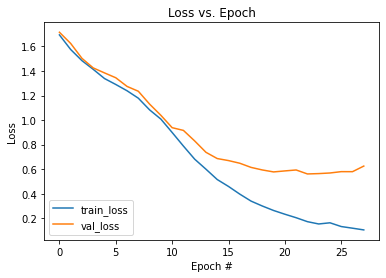

In [37]:
plt.plot(history.history["custom_loss"], label="train_loss")
plt.plot(history.history["val_custom_loss"], label="val_loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [38]:
custom_test_loss = main_model.evaluate(test_ds)
print(f'[INFO] Test Loss: {custom_test_loss}')

12/12 [==============================] - 4s 321ms/step - custom_loss: 0.5984
[INFO] Test Loss: 0.6203104853630066


In [39]:
# Save the weights of the model for better reproducibility
main_model.encoder.save_weights("encoder.h5")
main_model.decoder.save_weights("decoder.h5")

artifact = wandb.Artifact('model-weights', type='model')

# Add a file to the artifact's contents
artifact.add_file('encoder.h5')
artifact.add_file('decoder.h5')

# Save the artifact version to W&B and mark it as the output of this run
run.log_artifact(artifact)

# Inference
The inference module holds the code snippet to have translations from english to spanish. We also plot the attention weights of the translations. The attention weights are pretty neat to build intuitions.

In [40]:
encoder = main_model.encoder
decoder = main_model.decoder

In [41]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    encoder_hidden_fwd = tf.zeros((1, units))
    mod_hidden = tf.zeros((1, units))
    enc_out, enc_hidden_fwd = encoder(inputs, encoder_hidden_fwd)

    dec_hidden = enc_hidden_fwd
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, mod_hidden, attention_weights = decoder(dec_input, dec_hidden, mod_hidden, enc_out, t)
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [42]:
def plot_attention(attention, sentence, predicted_sentence, run, param):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    run.log({f"{param}": plt})
    plt.show()

In [43]:
def translate(sentence, run, param):

    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '), run, param)

## Make custom charts for wandb

In [44]:
def custom_chart(src, run, param):
    """Logs tables needed for custom charts

    Args:
        src: The source sentence
        run: The run object in wandb
        param: The parameter that is logged
    """
    translation, src, attn = evaluate(src)
    print(f"SRC: {src}")
    print(f"TRANSLATION: {translation}")
    print()
    
    attn_data = []
    src = src.split()
    translation =  translation.split()
    for m in range(len(translation)):
        for n in range(len(src)):
            attn_data.append([n, m, src[n], translation[m], attn[m, n]])

    run.log({f"{param}": wandb.Table(data=attn_data, columns=["s_ind", "t_ind", "s_word", "t_word", "attn"])})

In [45]:
custom_chart(u"i am a good boy.", run, "first_table")
custom_chart(u"will you come with me?", run, "second_table")
custom_chart(u"i want to go to your house.", run, "third_table")

SRC: <start> i am a good boy . <end>
TRANSLATION: soy un buen chico . <end> 

SRC: <start> will you come with me ? <end>
TRANSLATION: ¿ vendras conmigo ? <end> 

SRC: <start> i want to go to your house . <end>
TRANSLATION: quiero ir a tu casa . <end> 



## Upload the heat maps as images

Input: <start> how are you ? <end>
Predicted translation: ¿ como te estas ? <end> 


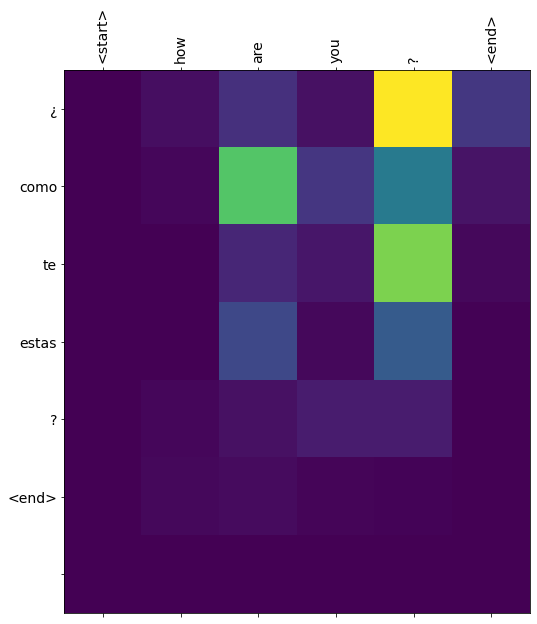

In [46]:
translate(u'how are you?', run, "first_heatmap")

Input: <start> i am good . <end>
Predicted translation: soy bueno . <end> 


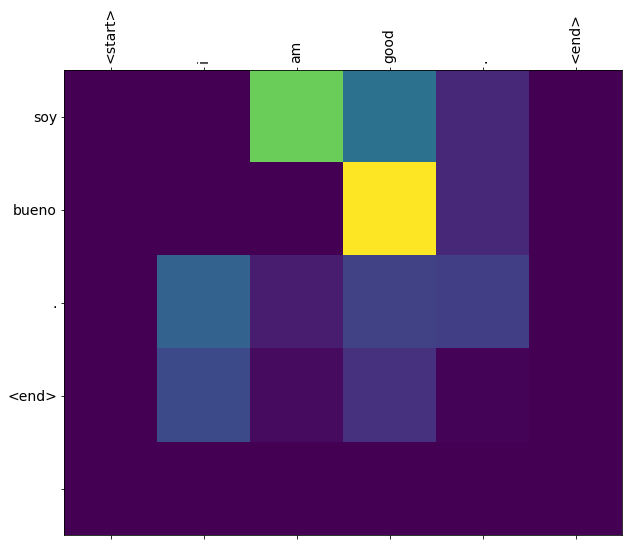

In [47]:
translate(u'i am good.', run, "second_heatmap")

Input: <start> i am going to school <end>
Predicted translation: voy a la escuela . <end> 


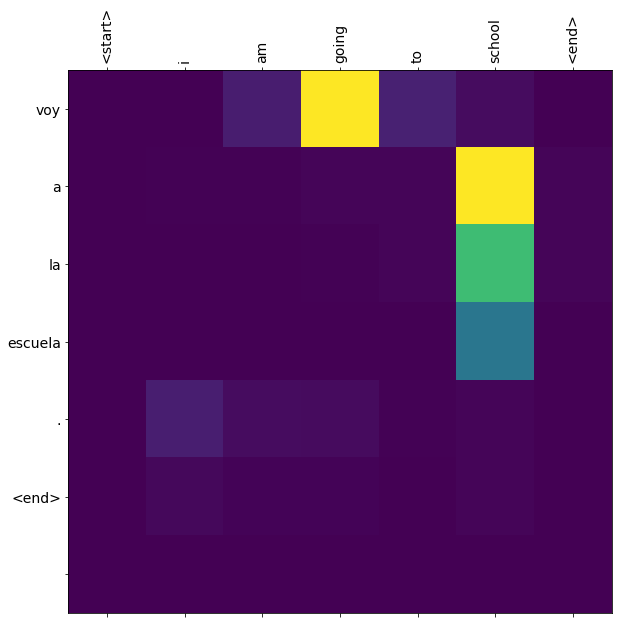

In [48]:
translate(u'i am going to school', run, "third_heatmap")

Input: <start> let us go home now <end>
Predicted translation: dejanos a ir a casa ahora . <end> 


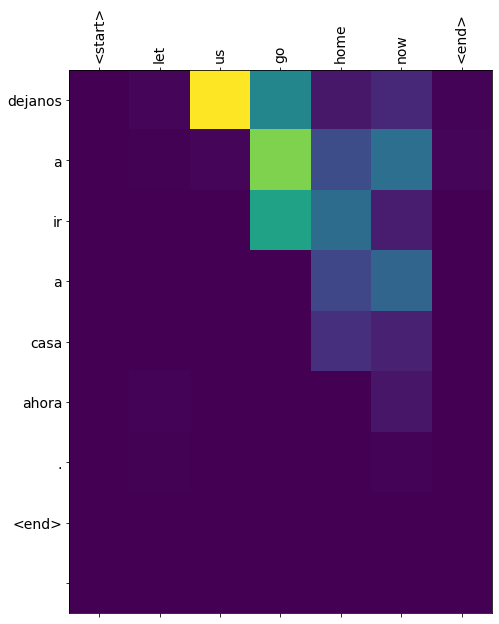

In [49]:
translate(u'let us go home now', run, "forth_heatmap")

Input: <start> why would you do this ? <end>
Predicted translation: ¿ por que harias esto ? <end> 


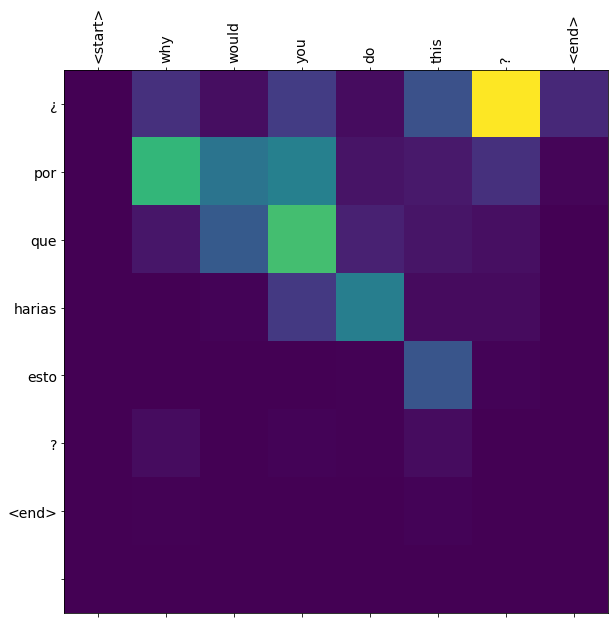

In [50]:
translate(u'why would you do this?', run, "fifth_heatmap")

Input: <start> do you want to see some magic ? <end>
Predicted translation: ¿ quieres ver algo de peso ? <end> 


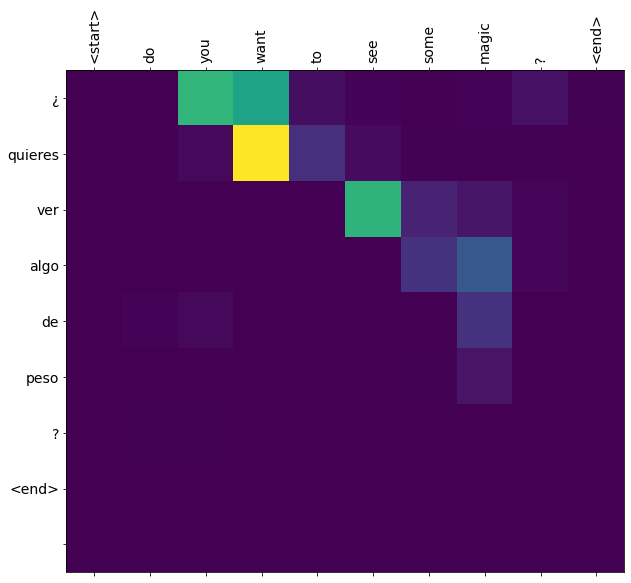

In [51]:
translate(u'do you want to see some magic?', run, "sixth_heatmap")

In [52]:
run.finish()

epoch,27
custom_loss,0.10586
val_custom_loss,0.62556
_runtime,1492
_timestamp,1615910136
_step,36


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
custom_loss,█▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_custom_loss,█▇▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
